In [ ]:
**Introduction.**

work with the MNIST dataset, which consists of images containing one of possibly ten digits, ranging from zero to nine.  Your goal will be to solve the MNIST problem (i.e., assign a digit label to each test image as accurately as possible) using custom-built deep learning models. Below there are a series of "problems", and each problem asks you to write some Python code to achieve a goal (e.g., train a neural network, or define a custom neural network)

: 

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Fill in the details for the "transform" variable
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.05), (0.05))])

# We will use a relatively large batch size of 128 here to
#  accelerate the training process
batch_size = 128

# Download the MNIST dataset and data loaders
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Label the classes
classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [ ]:
# Get info from dataset
print(f"Length of train data: {len(trainset)}\nLength of test data: {len(testset)}")

img, label = next(iter(trainloader))
print(f"Train loader include {len(trainloader)} batches of size {img.shape[0]}")
test_img, test_label = next(iter(testloader))
print(f"Train loader include {len(testloader)} batches of size {test_img.shape[0]}")
print(f"Shape of input image: {img.shape}")

class_names = trainset.classes
class_name_idx = trainset.class_to_idx
class_name_idx

Length of train data: 60000
Length of test data: 10000
Train loader include 469 batches of size 128
Train loader include 79 batches of size 128
Shape of input image: torch.Size([128, 1, 28, 28])


{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

(-0.5, 27.5, 27.5, -0.5)

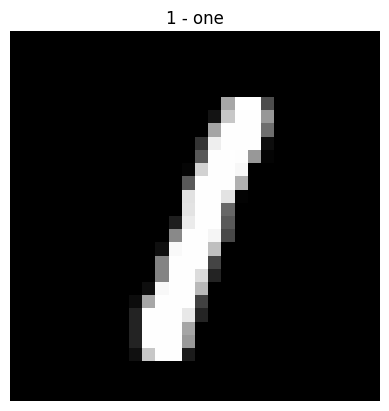

In [ ]:
# Visualize input data
# Generate a random int in range of trainset size
rand_idx = torch.randint(low=0, high=len(trainset), size=(1,))
sample = trainset[rand_idx.item()][0] / 20 + 0.05 # Unnormalize
plt.imshow(sample.squeeze(), cmap="gray")
plt.title(class_names[trainset[rand_idx.item()][1]])
plt.axis(False)

# Problem 1

In this problem we will start by creating the most naive architecture to solve an image recognition problem, in which we use only traditional fully-connected layers.  We will progressively move towards a more modern approach and witness improvements in performance that result.

**Part (a)**. A fully-connected neural network with 8 total layers of parameters.  Aside from the output layer, each layer has 50 hidden units.  We use ReLU activations.  We will call this network *NetFC*.  

In [ ]:
class NetFc(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
      super().__init__()
      self.fully_connected_layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=input_shape, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=output_shape)
      )


    def forward(self, x):
      output = self.fully_connected_layers(x)

      # Return the output of the network
      return output

**Part (b)**. In this part, we will create a function that trains the model for two epochs (i.e., two complete passes over the training data), and prints the loss of the model on each 100th minibatch. We use the Adam optimizer, and a cross entropy loss for classification.

In [ ]:
# This function takes in a pytorch model as 'net', and then trains it for two
#  epochs (i.e., two loops over teh entire dataset).  You may want to adjust
# the learning rate sometimes and we will pass that in as 'lr'.  You will also
# later need to vary the number of epochs of training, so we will pass that in
#  as 'n_epochs.  You will also need to pass in the 'trainloader' object to
# handle your data. Your function should return the trained model.
def trainMyModel(net: torch.nn.Module,
                 lr: float,
                 trainloader: torch.utils.data.DataLoader,
                 n_epochs: int):
  # Set a seed for reproducibility
  torch.manual_seed(42)
  # Define loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=net.parameters(),
                               lr=lr)
  # Training loop
  for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    # Calculate training loss for each batch of data and zero its value in each epoch
    train_loss = 0
    for batch, (X, y) in enumerate(trainloader):
      # Put tensors into device
      X, y = X.to(device), y.to(device)
      # Put model into training mode
      net.train()

      # Feed the model with the training data points in the current batch
      y_preds = net(X)

      # Compute training loss
      loss = loss_fn(y_preds, y)
      train_loss += loss

      # Zero the previous accumulated gradients
      optimizer.zero_grad()

      # Calculate gradients in loss function
      loss.backward()

      # Update weight and bias parameters w.r.t gradients
      optimizer.step()

      # Print out the process every 100 minibatch
      if batch % 100 == 0:
        print(f"Batch {batch}/{len(trainloader)} --- Loss: {train_loss/(batch + 1)}")

  print('Finished Training')
  return net



**Part (c)**. In this part, we will create a function that will take a trained model as input, and a data loader (for our test data), and return the accuracy of the model on the testing data.  The accuracy is reported to at least two decimal places. This function need not be general, but it should work with the 'testloader' that was created above for the MNIST dataset.

In [ ]:
# This function takes in a pytorch model as 'trainedNet', and then applied it
# to testing data that can be loaded using the 'testloader' object.  The
# function returns the accuracy of trainedNet on the whole testing dataset
# and prints the model's accuracy to the terminal (to at least two decimal
#  places of accuracy)

# Define accuracy function
def accuracy_fn(test_preds, y):
  num_correct_preds = torch.eq(test_preds, y).sum().item()
  acc = num_correct_preds / len(test_preds) * 100
  return acc

def testMyModel(trainedNet: torch.nn.Module,
                testloader: torch.utils.data.DataLoader):
  # Set test accuracy variable to zero in order to add up accuracies of all batches and take average test accuracy
  test_acc = 0
  # Put the model into testing mode
  trainedNet.eval()
  with torch.inference_mode():
    for X, y in testloader:
      # Put tensors into device
      X, y = X.to(device), y.to(device)

      test_logits = trainedNet(X)
      # Pass through softmax function and take the max argument
      test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_acc += accuracy_fn(test_preds, y)
  test_acc /= len(testloader)
  print(f'Accuracy of the network on the 10000 test images: {test_acc} %')
  return test_acc

In [ ]:
# Train your model.
net = NetFc(input_shape=28*28, hidden_units=50, output_shape=10).to(device);
lr = 0.01;
n_epochs = 2;
trainedNet = trainMyModel(net,lr,trainloader,n_epochs);

# Test your model
testMyModel(trainedNet,testloader)

Epoch 1/2
Batch 0/469 --- Loss: 2.305591106414795
Batch 100/469 --- Loss: 0.9684598445892334
Batch 200/469 --- Loss: 0.6927343010902405
Batch 300/469 --- Loss: 0.5761390924453735
Batch 400/469 --- Loss: 0.5087199211120605
Epoch 2/2
Batch 0/469 --- Loss: 0.16010013222694397
Batch 100/469 --- Loss: 0.25883546471595764
Batch 200/469 --- Loss: 0.2430177628993988
Batch 300/469 --- Loss: 0.24098831415176392
Batch 400/469 --- Loss: 0.23913398385047913
Finished Training
Accuracy of the network on the 10000 test images: 94.56091772151899 %


94.56091772151899

# Problem 2

Now we will see the advantages of skip connections in a deep neural network.  We create another fully connected neural network called *NetFcRes* that has two "skip connections" in it.  By "skip connection", this mean a direct connection from an earlier layer *directly* to a later layer in the network. For example, a skip connection between the first layer and third layer means that the input to the fourth layer is the sum of the output of first layer and the third layers. In this problem, we create a network with two skip connections: one from the output of the first layer to the output of the third layer; and one from the output of the fifth layer to  the output of the 7th layer.  Then, we use our training and testing functions to train and evaluate the performance of the *NetFcRes* model. 

In [ ]:
class NetFcRes(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
      super().__init__()
      self.fully_connected_layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=input_shape, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.Linear(in_features=hidden_units, out_features=output_shape)
      )

    def forward(self, x):
      features = []
      # Flatten image inputs
      layer = self.fully_connected_layers[0]
      x = layer(x)
      # Store features before fourth layer which takes in the output of two earlier layers
      for layer in self.fully_connected_layers[1:4]:
        x = layer(x)
        # Append features of each layer
        features.append(x)
        x = F.relu(x)
      # Implement the skip connection for the output of first and third layers
      x = F.relu(features[0] + features[2])
      x = self.fully_connected_layers[4](x)
      # Store features before eights layer which takes in the output of two earlier layers
      for layer in self.fully_connected_layers[4:-1]:
        x = layer(x)
        features.append(x)  # store the features
        x = F.relu(x)
      # Implement the skip connection for the output of fifth and seventh layers
      x = F.relu(features[4] + features[6])
      y = self.fully_connected_layers[8](x)
      # Return the output of the network
      return y


In [ ]:
# Train your model.
net = NetFcRes(input_shape=28*28, hidden_units=50, output_shape=10).to(device);
lr = 0.01;
n_epochs = 2;
trainedNet = trainMyModel(net,lr,trainloader,n_epochs);

# Test your model
testMyModel(trainedNet,testloader)

Epoch 1/2
Batch 0/469 --- Loss: 2.3455593585968018
Batch 100/469 --- Loss: 0.6686679720878601
Batch 200/469 --- Loss: 0.49398818612098694
Batch 300/469 --- Loss: 0.4310563802719116
Batch 400/469 --- Loss: 0.3906792998313904
Epoch 2/2
Batch 0/469 --- Loss: 0.20001967251300812
Batch 100/469 --- Loss: 0.25458434224128723
Batch 200/469 --- Loss: 0.2462182641029358
Batch 300/469 --- Loss: 0.2447207272052765
Batch 400/469 --- Loss: 0.2422735095024109
Finished Training
Accuracy of the network on the 10000 test images: 94.4620253164557 %


94.4620253164557

# Problem 3

Now we will see the advantages of convolutional structures in a deep neural network. We create convolutional neural network called 'NetCnn' that has the following structure:

layer1: 8 3x3 convolutional filters, one pixel of zero-padding, and stride of one

layer2: 16 3x3 convolutional filters, one pixel of zero-padding, and stride of one

layer3: 2x2 max pooling, with stride of 2. No zero-padding.

layer4: 32 3x3 convolutional filters, one pixel of zero-padding, and stride of one

layer5: 64 3x3 convolutional filters, one pixel of zero-padding, and stride of one

layer6: 2x2 max pooling, with stride of 2. No zero-padding.

layer7: a fully connected layer of 50 neurons.

Layer8: a fully connected layer of 10 neurons.

We assume ReLU activations and will need to decide precisely where to put these activation functions.  If done correctly, we would have a substantial improvement over *NetFcRes*, the fully-connected network with skip connections.  

In [ ]:
# Convolutional model - adding in convolutional layers

class NetCnn(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=1,
                    out_channels=8,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=8,
                    out_channels=16,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=16,
                    out_channels=32,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=32,
                    out_channels=64,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=64*7*7, out_features=50),
          nn.ReLU(),
          nn.Linear(in_features=50, out_features=10)
      )


    def forward(self, x):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      output = self.classifier(x)
      #Return output of model
      return output


In [ ]:
# Train your model.
net = NetCnn().to(device);
lr = 0.001;
n_epochs = 2;

trainedNet = trainMyModel(net,lr,trainloader,n_epochs);

# Test your model
testMyModel(trainedNet,testloader)

Epoch 1/2
Batch 0/469 --- Loss: 2.3040871620178223
Batch 100/469 --- Loss: 0.4352353513240814
Batch 200/469 --- Loss: 0.2738005518913269
Batch 300/469 --- Loss: 0.21233244240283966
Batch 400/469 --- Loss: 0.1760067194700241
Epoch 2/2
Batch 0/469 --- Loss: 0.05593882128596306
Batch 100/469 --- Loss: 0.050864577293395996
Batch 200/469 --- Loss: 0.04738549143075943
Batch 300/469 --- Loss: 0.04457249492406845
Batch 400/469 --- Loss: 0.04518839344382286
Finished Training
Accuracy of the network on the 10000 test images: 98.77373417721519 %


98.77373417721519

# Problem 4

In this last problem, we will add batch normalization layers to the network.  Batch normalization, and its variants (e.g., "layer norm") are another structure that is now widely-used in modern deep neural networks.  In this problem, we will design a neural network called *NetCnnBn* with the exact same structure as 'NetCnn' except we will add two batch normalization layers in the following locations: (i) after the 2nd convolutional layer, and (ii) after the 1st fully connected layer.  

In [ ]:
# Convolutional model - adding in convolutional layers

class NetCnnBn(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=1,
                    out_channels=8,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=8,
                    out_channels=16,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.BatchNorm2d(num_features=16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=16,
                    out_channels=32,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=32,
                    out_channels=64,
                    kernel_size=3,
                    stride=1,
                    padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=64*7*7, out_features=50),
          nn.BatchNorm1d(num_features=50),
          nn.ReLU(),
          nn.Linear(in_features=50, out_features=10)
      )


    def forward(self, x):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      output = self.classifier(x)
      #Return output of model
      return output


In [ ]:
# Train your model.
net = NetCnnBn().to(device);
lr = 0.001;
n_epochs = 2;
trainedNet = trainMyModel(net,lr,trainloader,n_epochs);

# Test your model
testMyModel(trainedNet,testloader)

Epoch 1/2
Batch 0/469 --- Loss: 2.453518867492676
Batch 100/469 --- Loss: 0.5858493447303772
Batch 200/469 --- Loss: 0.36083585023880005
Batch 300/469 --- Loss: 0.2680508494377136
Batch 400/469 --- Loss: 0.21644000709056854
Epoch 2/2
Batch 0/469 --- Loss: 0.06092465668916702
Batch 100/469 --- Loss: 0.038225382566452026
Batch 200/469 --- Loss: 0.03433413431048393
Batch 300/469 --- Loss: 0.03286709636449814
Batch 400/469 --- Loss: 0.03331935405731201
Finished Training
Accuracy of the network on the 10000 test images: 98.82318037974683 %


98.82318037974683